### **Visualization of Hand Pose Estimation**

This notebook is used to visualize hand pose estimation results for specified datasets & case from *UPenn's data*. You may find available datasets and visualization options below


In [1]:
import json
import os
import pickle
import shutil
import sys
import matplotlib.pyplot as plt
import cv2
import glob
import numpy as np
from PIL import Image
import pandas as pd


from ego4d.internal.human_pose.dataset import (
    get_synced_timesync_df,
    SyncedEgoExoCaptureDset,
)
from ego4d.internal.human_pose.pose_estimator import PoseModel
from ego4d.internal.human_pose.utils import (
    check_and_convert_bbox,
    draw_bbox_xyxy,
    draw_points_2d,
    get_exo_camera_plane,
    get_region_proposal,
    get_bbox_fromKpts,
    get_two_small_bboxes,
    aria_rotate_kpts,
    left_right_bboxes_div,
    get_largest_bboxes
)
%matplotlib inline

apex is not installed
apex is not installed
apex is not installed


**Choose dataset**

In [3]:
# All datasets
dataset_dir = f'/mnt/shared/ego4dData/cache'
print('All datasets:\n', os.listdir(dataset_dir))

All datasets:
 ['0324_Piano_1', '0324_Piano_1_origSize', '0630_Cooking_4', 'iiith_cooking_01', 'iu_bike', 'iu_music', 'unc_T1']


#### Body bbox visualization

In [4]:
################## MODIFY ###################
test_case = '0630_Cooking_4'
exo_cam_names = ['cam01','cam02','cam03','cam04','cam06']
#############################################

# Load camera image path
dataset_dir = os.path.join('/mnt/shared/ego4dData/cache', f'{test_case}', 'dataset')
dset = {curr_cam : sorted(glob.glob(os.path.join(dataset_dir, 'frames', curr_cam, '*'))) for curr_cam in exo_cam_names}

# Load in bbox file
bbox_dir = os.path.join(dataset_dir, 'body/bbox')
bbox_file = os.path.join(bbox_dir, "bbox.pkl")
with open(bbox_file, "rb") as f:
    body_bboxes = pickle.load(f)

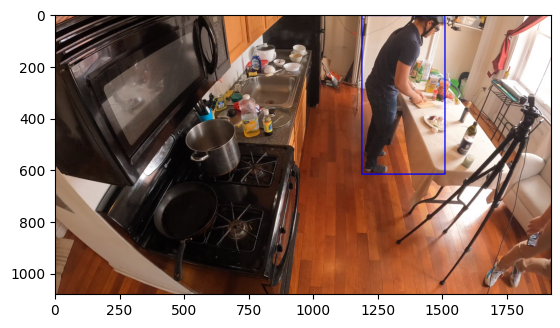

In [5]:
######################
rand_idx = 33 # 33,75,78
rand_cam = 'cam02'
######################

rand_image_path = dset[rand_cam][rand_idx]
curr_rand_bbox = body_bboxes[rand_idx][rand_cam]
# curr_rand_bbox = body_bboxes[32][rand_cam]

rand_img = cv2.imread(rand_image_path)
rand_bbox_img = draw_bbox_xyxy(rand_img, curr_rand_bbox)

plt.figure()
plt.imshow(rand_bbox_img[:,:,::-1])

#### Body pose2d estimation visualization

In [6]:
########### Parameter ###########
test_case = '0630_Cooking_4'
exo_cam_names = ['cam01','cam02','cam03','cam04']
#################################

# Load camera image path
dataset_dir = os.path.join('/mnt/shared/ego4dData/cache', f'{test_case}', 'dataset')
dset = {curr_cam : sorted(glob.glob(os.path.join(dataset_dir, 'frames', curr_cam, '*'))) for curr_cam in exo_cam_names}

# Body pose2d model
pose_config = "external/mmlab/mmpose/configs/wholebody/2d_kpt_sview_rgb_img/topdown_heatmap/coco-wholebody/hrnet_w48_coco_wholebody_384x288_dark_plus.py"
pose_checkpoint = "https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_wholebody_384x288_dark-f5726563_20200918.pth"
body_pose_model = PoseModel(
    pose_config, 
    pose_checkpoint, 
    rgb_keypoint_thres=0.7, 
    rgb_keypoint_vis_thres=0.7)

# Load body pose2d estimation result
pose2d_file = os.path.join(f'/mnt/shared/ego4dData/cache/{test_case}/dataset', 'body/pose2d', 'pose2d.pkl')
assert os.path.exists(pose2d_file), f"{pose2d_file} does not exist"
with open(pose2d_file, "rb") as f:
        poses2d = pickle.load(f)

bbox_dir = os.path.join(f'/mnt/shared/ego4dData/cache/{test_case}/dataset', 'body/bbox')
bbox_file = os.path.join(bbox_dir, "bbox.pkl")
with open(bbox_file, "rb") as f:
    bboxes = pickle.load(f)

load checkpoint from http path: https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_wholebody_384x288_dark-f5726563_20200918.pth


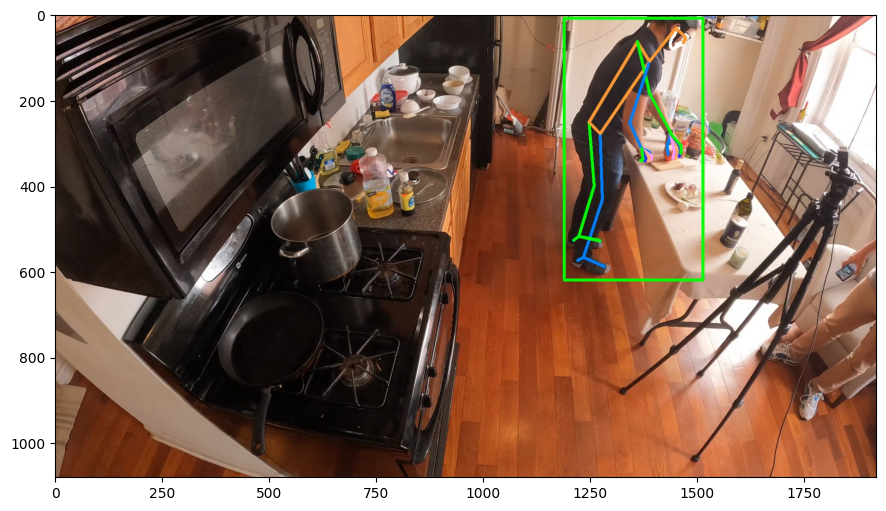

In [8]:
#######################
rand_idx = 16
rand_cam = 'cam02'
#######################
rand_img_path = dset[rand_cam][rand_idx]
rand_img = cv2.imread(rand_img_path)

curr_pose2d = poses2d[rand_idx][rand_cam]
curr_bbox = np.append(bboxes[rand_idx][rand_cam], 1)
pose_results = [{'bbox': curr_bbox,
                 "keypoints":curr_pose2d}]
# Visualization
save_path = f'temp_vis_dir/body_pose2d_{test_case}_{rand_cam}.jpg'
body_pose_model.draw_poses2d(pose_results, rand_img, save_path)

vis_img = cv2.imread(save_path)
plt.figure(figsize=(12,6))
plt.imshow(vis_img[:,:,::-1])

# # Check hand confidence
# print('Left hand:\n')
# print(curr_pose2d[91:112,2])
# print('\nRight hand:\n')
# print(curr_pose2d[113:,2])

#### Hand pose2d estimation visualization

In [14]:
########### Parameter ###########
test_case = '0630_Cooking_4'
exo_cam_names = ['cam01','cam02','cam03','cam04']
ego_cam_name = 'cam05'
kpts_vis_threshold = 0.1
#################################

# Load camera image path
dataset_dir = os.path.join('/mnt/shared/ego4dData/cache', f'{test_case}', 'dataset')
dset = {curr_cam : sorted(glob.glob(os.path.join(dataset_dir, 'frames', curr_cam, '*'))) for curr_cam in exo_cam_names}
dset[ego_cam_name] = sorted(glob.glob(os.path.join(dataset_dir, 'frames', ego_cam_name, '*')))

# Body pose2d model
hand_pose_config = 'external/mmlab/mmpose/configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/coco_wholebody_hand/hrnetv2_w18_coco_wholebody_hand_256x256_dark.py'
hand_pose_ckpt = 'https://download.openmmlab.com/mmpose/hand/dark/hrnetv2_w18_coco_wholebody_hand_256x256_dark-a9228c9c_20210908.pth'
hand_pose_model = PoseModel(hand_pose_config, 
    hand_pose_ckpt, 
    rgb_keypoint_thres=kpts_vis_threshold, 
    rgb_keypoint_vis_thres=kpts_vis_threshold,
    refine_bbox=False,
    thickness=3)

# Load body pose2d estimation result
exo_pose2d_file = os.path.join(f'/mnt/shared/ego4dData/cache/{test_case}/dataset', 'hand/pose2d', 'exo_pose2d.pkl')
assert os.path.exists(exo_pose2d_file), f"{exo_pose2d_file} does not exist"
with open(exo_pose2d_file, "rb") as f:
        exo_hand_poses2d = pickle.load(f)
ego_pose2d_file = os.path.join(f'/mnt/shared/ego4dData/cache/{test_case}/dataset', 'hand/pose2d', 'ego_pose2d.pkl')
assert os.path.exists(ego_pose2d_file), f"{ego_pose2d_file} does not exist"
with open(ego_pose2d_file, "rb") as f:
        ego_hand_poses2d = pickle.load(f)
# Load exo and ego hand bbox result
exo_bbox_dir = os.path.join(f'/mnt/shared/ego4dData/cache/{test_case}/dataset', 'hand/bbox/exo_bbox.pkl')
with open(exo_bbox_dir, "rb") as f:
    exo_hand_bboxes = pickle.load(f)
ego_bbox_dir = os.path.join(f'/mnt/shared/ego4dData/cache/{test_case}/dataset', 'hand/bbox/ego_bbox.pkl')
with open(ego_bbox_dir, "rb") as f:
    ego_hand_bboxes = pickle.load(f)

load checkpoint from http path: https://download.openmmlab.com/mmpose/hand/dark/hrnetv2_w18_coco_wholebody_hand_256x256_dark-a9228c9c_20210908.pth


Text(0.5, 1.0, 'Hand pose2d visualization for ego camera with threshold=0.1')

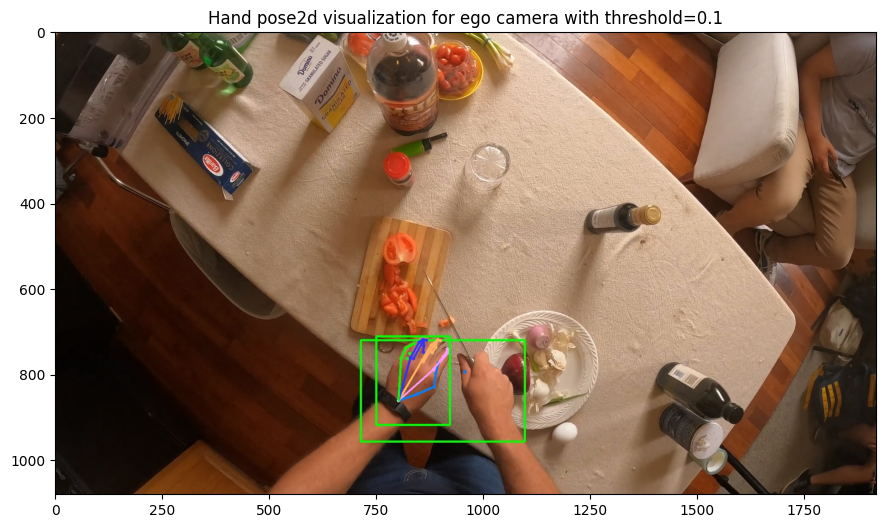

In [19]:
#######################
rand_idx = 297
rand_cam = 'cam05'
#######################

# Load in image
rand_img_path = dset[rand_cam][rand_idx]

if rand_cam == ego_cam_name:
    curr_pose2d = ego_hand_poses2d[rand_idx]
    curr_bbox = ego_hand_bboxes[rand_idx]
else:
    curr_pose2d = exo_hand_poses2d[rand_idx][rand_cam]
    curr_bbox = exo_hand_bboxes[rand_idx][rand_cam]

# Create pose2d results from .pkl file
pose_results = [{'bbox': np.append(curr_bbox[i], 1),
                 "keypoints":curr_pose2d[i]} for i in range(2)]

# Visualization
save_path = f'temp_vis_dir/body_pose2d_{test_case}_{rand_cam}.jpg'
vis_twoHand = cv2.imread(rand_img_path)
hand_pose_model.draw_poses2d([pose_results[0]], vis_twoHand, save_path)
vis_twoHand = cv2.imread(save_path)
hand_pose_model.draw_poses2d([pose_results[1]], vis_twoHand, save_path)

vis_img = cv2.imread(save_path)
plt.figure(figsize=(12,6))
plt.imshow(vis_img[:,:,::-1])
plt.title(f'Hand pose2d visualization for ego camera with threshold={kpts_vis_threshold}')